In [2]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting
import os
import analysis_tools as at 

from lsst.ts.wep.task.GenerateDonutDirectDetectTask import (
    GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
)

from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTaskConfig, CutOutDonutsScienceSensorTask
)

from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask, CalcZernikesTaskConfig
)


from lsst.obs.lsst import LsstCam
import lsst.afw.image as afwImage
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix
import numpy as np
from astropy.time import Time
from lsst.obs.lsst import Latiss
import lsst

from copy import copy

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


The simulations were performed with https://github.com/suberlak/AOS/blob/main/AOS_DM-37533_auxTel_batoid_zk_take2.ipynb. We inject 200 nm of wavefront perturbations to invidual Zernikes using a phase screen.

We select and cutout donuts using WEP tasks. We then fit with WEP `CalcZernikesTask` with or without transpose (i.e. commenting out the `.T` in these lines in `CalcZernikesTask`: 
     
     
       wfEsti.setImg(
                fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra),#.T,
                blendOffsets=blendOffsetsExtra.tolist(),
            )
       wfEsti.setImg(
                fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra),#.T,
                blendOffsets=blendOffsetsIntra.tolist(),
            )
). The default includes the transpose done to both intra- and extra-focal images. 


The same donut cutouts are also fit with WEP directly (without the overhead of the task),  as well as with old CWFS code for comparison. 




# We do two loops: first getting the donut catalogs in the loop, and then making the cutouts / performing WEP task fitting

In [2]:
# Load a saved simulation image 
donut_catalog = {}
for i in range(5,12):
    seed=0
    donut_catalog[i] = {}
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37533',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zktruth']

    # make exposure
    intra_exposure = at.make_exposure(intra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(extra_image, focusZ=-0.8)
    print(id(intra_exposure))
    
    # common settings for donut detection task,
    # donut cutting out task zernike estimation task...
    
    focalLength = 21.6 # meters 
    obscuration = 0.3525 # ratio 
    apertureDiameter = 1.2 # meters 
    defocalOffset = 32.8 
    pixelSize = 10.0e-6 # meters 
    opticalModel = 'onAxis'
    # pass to WEP, fit transposed and untransposed 

    newConfig = GenerateDonutDirectDetectTaskConfig()
    newConfig.measurementTask.nSigmaDetection = 5
    newConfig.initialCutoutPadding = 40
    
    # Set auxTel parameters
    newConfig.instObscuration = obscuration
    newConfig.instFocalLength = focalLength
    newConfig.instApertureDiameter = apertureDiameter
    newConfig.instDefocalOffset = defocalOffset
    newConfig.instPixelSize = pixelSize
    newConfig.opticalModel = opticalModel
    
    # Set donut selection parameters
    newConfig.donutSelector.useCustomMagLimit = True
    newConfig.donutSelector.magMin = 8.
    newConfig.donutSelector.magMax = 20.
    newConfig.donutSelector.unblendedSeparation = 200


    camera = Latiss().getCamera()
    newTask = GenerateDonutDirectDetectTask(config=newConfig)
    donut_catalog_intra = newTask.run(copy(intra_exposure), camera).donutCatalog
    donut_catalog_extra = newTask.run(copy(extra_exposure), camera).donutCatalog
    donut_catalog[i]['intra'] = donut_catalog_intra
    donut_catalog[i]['extra'] = donut_catalog_extra 

# store donut catalog for the future use...
fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_donut_catalogs')
np.savez(fpath,
             donutcat=donut_catalog
        )
print(f'saved as {fpath}')


DM-37533/auxtel_b_seed0_image_truth_z5.npz
139658986207984


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 71 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 71 of 71 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/71 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 100 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 100 of 100 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, n

DM-37533/auxtel_b_seed0_image_truth_z6.npz
139639537075952


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 64 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 64 of 64 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/64 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 110 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 110 of 110 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, n

DM-37533/auxtel_b_seed0_image_truth_z7.npz
139639395408240


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 61 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 61 of 61 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/61 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 87 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 87 of 87 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.l

DM-37533/auxtel_b_seed0_image_truth_z8.npz
139639535786672


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 58 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 58 of 58 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/58 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 94 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 94 of 94 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.l

DM-37533/auxtel_b_seed0_image_truth_z9.npz
139639395346288


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 63 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 63 of 63 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/63 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 94 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 94 of 94 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.l

DM-37533/auxtel_b_seed0_image_truth_z10.npz
139639395343024


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 65 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 65 of 65 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/65 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 87 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 87 of 87 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.l

DM-37533/auxtel_b_seed0_image_truth_z11.npz
139639395978096


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 62 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 62 of 62 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 1/62 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 89 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 89 of 89 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
/sdf/group/rubin/sw/conda/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:64: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.l

Use previously-stored donut catalog ... 

In [34]:
fpath = os.path.join('DM-37533','auxtel_b_seed{seed}_donut_catalogs.npz')
file = np.load(fpath, allow_pickle=True)
donut_catalog=file['donutcat'].item()

In [37]:
donutSize = 240 
focalLength = 21.6 # meters 
obscuration = 0.3525 # ratio 
apertureDiameter = 1.2 # meters 
defocalOffset = 32.8 
pixelSize = 10.0e-6 # meters 
opticalModel = 'onAxis'
    
results = {} 
for i in range(5,12):
    seed=0
    results[i] = {}
    fname = f"auxtel_b_seed{seed}_image_truth_z{i}.npz"
    fpath = os.path.join('DM-37533',fname)
    print(fpath)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']
    zk = npz['zktruth']
    results[i]['truth']=zk
    # make exposure
    intra_exposure = at.make_exposure(intra_image, focusZ=0.8)
    extra_exposure = at.make_exposure(extra_image, focusZ=-0.8)
    
    cutOutConfig = CutOutDonutsScienceSensorTaskConfig()
    cutOutConfig.instObscuration = obscuration
    cutOutConfig.instFocalLength = focalLength
    cutOutConfig.instApertureDiameter = apertureDiameter
    cutOutConfig.instDefocalOffset = defocalOffset
    cutOutConfig.instPixelSize = pixelSize
    cutOutConfig.opticalModel = opticalModel
    cutOutConfig.donutStampSize = donutSize
    cutOutConfig.donutTemplateSize = donutSize
    cutOutConfig.initialCutoutPadding = 40

    cutOutTask = CutOutDonutsScienceSensorTask(config=cutOutConfig)
    cutOuts = cutOutTask.run([extra_exposure, intra_exposure], 
                             [donut_catalog[i]['extra'], donut_catalog[i]['intra'] ], 
                             camera)

    results[i]['donut_intra'] = cutOuts.donutStampsIntra
    results[i]['donut_extra'] = cutOuts.donutStampsExtra
    
    calcZernikesConfig = CalcZernikesTaskConfig()
    calcZernikesConfig.instObscuration = obscuration
    calcZernikesConfig.instFocalLength = focalLength
    calcZernikesConfig.instApertureDiameter =apertureDiameter
    calcZernikesConfig.instDefocalOffset = defocalOffset
    calcZernikesConfig.instPixelSize = pixelSize
    calcZernikesConfig.opticalModel = opticalModel
    calcZernikesConfig.combineZernikes.sigma=2

    # Initiate the task with our given configuration
    calcZernikesTask = CalcZernikesTask(config=calcZernikesConfig)

    # Run the CalcZernikes task
    calcZernikesOutput = calcZernikesTask.run(
        cutOuts.donutStampsExtra, 
        cutOuts.donutStampsIntra)

    # illustrate the donut stamp, result transposed, result untransposed, input... 

    zernOutRaw = calcZernikesOutput.outputZernikesRaw
    zernOutAvg = calcZernikesOutput.outputZernikesAvg

    print(zernOutRaw)
    results[i]['zernOutAvg'] = zernOutAvg

# store the results
fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_no_transpose')
np.savez(fpath,
             results=results
        )
print(f'saved as {fpath}')


DM-37533/auxtel_b_seed0_image_truth_z5.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-7.04517956e-03 -1.23731960e-01  1.11302854e-02  9.72133870e-03
  -2.83425176e-03  9.47079016e-04 -4.04435491e-03  2.69730761e-04
  -1.51851927e-04  3.27107850e-05  2.07242569e-04 -5.59952381e-04
   2.26271369e-04 -1.03133006e-03 -3.99577956e-05 -3.97540125e-04
  -1.51968527e-03  9.66893934e-04  8.36137314e-05]]
DM-37533/auxtel_b_seed0_image_truth_z6.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-8.19603866e-03  2.46649799e-03 -1.12440445e-01  9.12558487e-03
  -1.28558916e-03  2.96097967e-03 -4.79927577e-03  2.05202654e-04
  -5.92179434e-04  4.19866592e-04  2.61718820e-04 -4.48861872e-04
  -3.02736386e-04 -8.25843107e-04 -2.84809669e-05 -4.09045744e-04
  -1.34431511e-03  9.95489269e-04  8.80083612e-05]]
DM-37533/auxtel_b_seed0_image_truth_z7.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-5.40970395e-03 -5.70980324e-03  1.55739986e-02 -1.93866416e-01
  -3.91624780e-03  1.67947036e-02 -4.67876665e-03  4.64729178e-04
  -4.69957160e-05  6.60221822e-04 -6.26807134e-04 -7.64300186e-04
   6.69849707e-04  7.90023684e-03 -1.05333125e-04 -5.42187909e-04
  -1.34453005e-03  2.26923023e-03 -2.52045794e-05]]
DM-37533/auxtel_b_seed0_image_truth_z8.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-6.30523893e-03  6.02679500e-03  1.22094233e-02  5.54799038e-03
  -2.05066133e-01  1.86927977e-03 -1.33323127e-02  1.80972857e-04
  -2.92048732e-05  3.26837029e-04 -5.88965982e-05 -4.69837891e-04
   8.81585701e-03  4.38474954e-04  1.76381922e-04 -4.28564813e-04
  -5.31388002e-04  7.33108769e-04  2.27324165e-04]]
DM-37533/auxtel_b_seed0_image_truth_z9.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-7.10936487e-03 -5.25600897e-03  1.72003735e-02  7.59125201e-03
  -2.89195424e-03 -1.15724611e-01 -2.96259576e-03  3.04885743e-04
  -2.31061615e-04  4.67284351e-04 -9.65397405e-04 -2.11534711e-03
   2.63634950e-04 -3.03794332e-04 -4.78835579e-05 -1.75419898e-04
  -1.73441621e-03  7.98566341e-04  6.61254242e-05]]
DM-37533/auxtel_b_seed0_image_truth_z10.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-7.72829655e-03 -5.97448945e-04  7.50377620e-03  8.63414477e-03
  -3.51851638e-03  9.87264430e-04 -1.20347838e-01  2.16595722e-04
  -8.10868962e-05  4.87271381e-04 -8.25025405e-04  7.00526073e-04
   4.75672195e-04 -6.93144075e-04  1.70569174e-04 -3.82114118e-04
  -1.79569366e-03  1.26888312e-03  8.14082217e-05]]
DM-37533/auxtel_b_seed0_image_truth_z11.npz
no transpose!


INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


[[-2.18086776e-01  1.55674308e-01  9.03734438e-02  3.11653792e-01
  -1.84697050e-01 -4.55815819e-03  1.87943508e-02 -1.62106961e-01
  -1.15305130e-02 -2.05999731e-02 -1.84836012e-02  1.52414440e-02
   4.07121616e-02 -6.82313251e-02 -4.59893002e-03 -1.09727742e-04
  -2.18369767e-03  3.66556919e-03  1.08747591e-02]]
saved as DM-37533/auxtel_b_seed0_result_wep_no_transpose


Use the same donut image stamps, but fit with WEP directly ... Fit also with CWFS for good measure. 

In [63]:
direct_results = {}

# run WEP 
for i in range(5,12):
    direct_results[i] = {}
    print(i)
    intra_stamp = results[i]['donut_intra'][0]
    fieldXYIntra = intra_stamp.calcFieldXY()
    print('intra', fieldXYIntra)

    extra_stamp = results[i]['donut_extra'][0]
    fieldXYExtra = extra_stamp.calcFieldXY()
    print('extra', fieldXYExtra)

    donut_size =  np.shape(intra_stamp.stamp_im.image.array)[0]

    model = 'onAxis'


    wepZk= at.fit_ts_wep(intra_stamp.stamp_im.image.array, 
                         extra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         sizeInPix = donut_size,
                         opticalModel=model
                        )

    # run CWFS with incorrect obscuration
    cwfsZk = at.fit_cwfs(intra_stamp.stamp_im.image.array, 
                         extra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         side = int(donut_size/2), 
                         opticalModel=model
                        )

    wepZkSwap= at.fit_ts_wep(extra_stamp.stamp_im.image.array, 
                         intra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         sizeInPix = donut_size,
                         opticalModel=model
                        )

    # run CWFS with incorrect obscuration
    cwfsZkSwap = at.fit_cwfs(extra_stamp.stamp_im.image.array, 
                         intra_stamp.stamp_im.image.array, 
                         fieldXYIntra=fieldXYIntra, 
                         fieldXYExtra=fieldXYExtra, 
                         side = int(donut_size/2), 
                         opticalModel=model
                        )

    direct_results[i]['wepZk'] = wepZk
    direct_results[i]['wepZkSwap'] = wepZkSwap
    direct_results[i]['cwfsZk'] = cwfsZk
    direct_results[i]['cwfsZkSwap'] = cwfsZkSwap
        
# store all the results in one file 
fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_cwfs_direct')
np.savez(fpath,
             directresults=direct_results
        )
print(f'saved as {fpath}')


5
intra (-0.0023392111111111176, -0.01092517916666666)
extra (-0.002365793055555557, -0.010951761111111107)
6
intra (-0.0023392111111111176, -0.01092517916666666)
extra (-0.002365793055555557, -0.01092517916666666)
7
intra (-0.0023392111111111176, -0.01079226944444444)
extra (-0.002365793055555557, -0.01079226944444444)
8
intra (-0.0022063013888888937, -0.010951761111111107)
extra (-0.0022063013888888937, -0.010951761111111107)
9
intra (-0.0023392111111111176, -0.01092517916666666)
extra (-0.002365793055555557, -0.010951761111111107)
10
intra (-0.0023392111111111176, -0.010951761111111107)
extra (-0.002365793055555557, -0.010951761111111107)
11
intra (-0.002365793055555557, -0.01092517916666666)
extra (-0.002365793055555557, -0.010951761111111107)




saved as DM-37533/auxtel_b_seed0_result_wep_cwfs_direct


Compare WEP as a task with/without transpose:

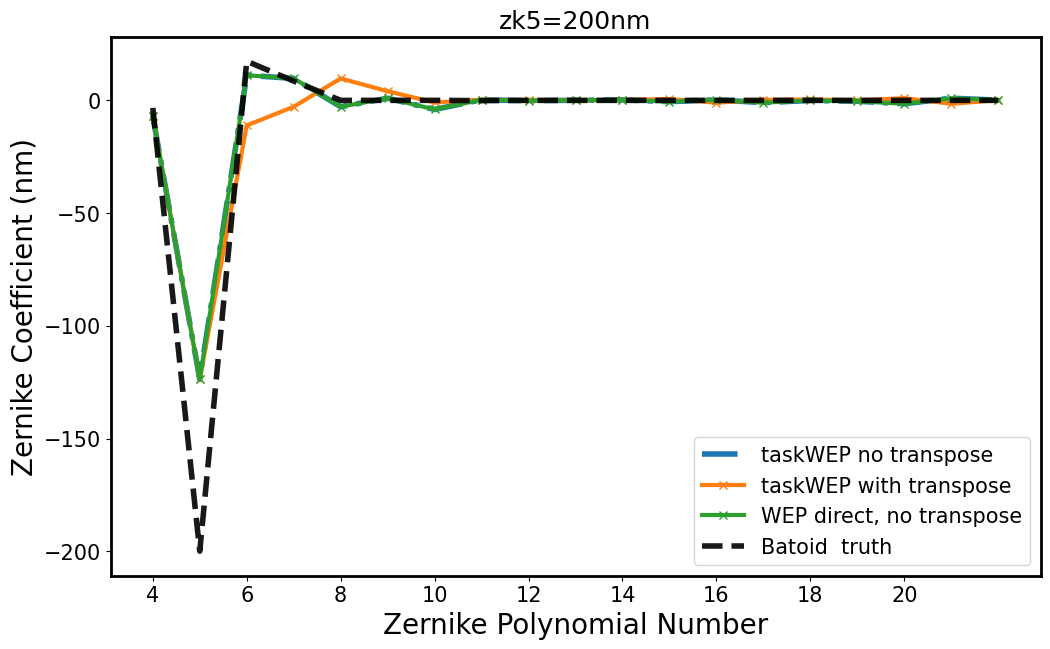

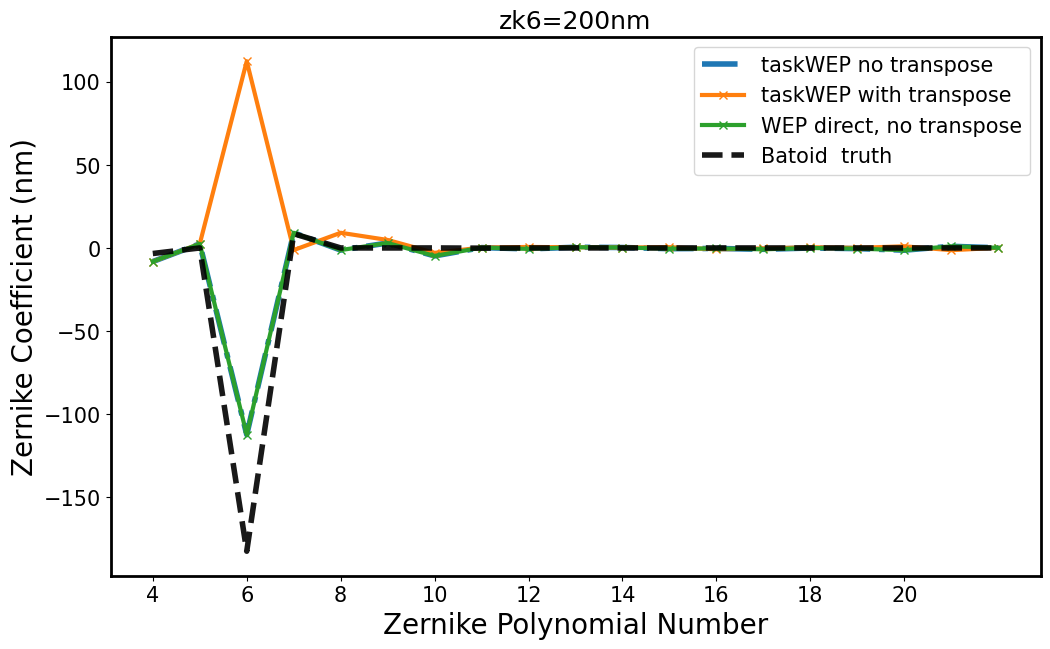

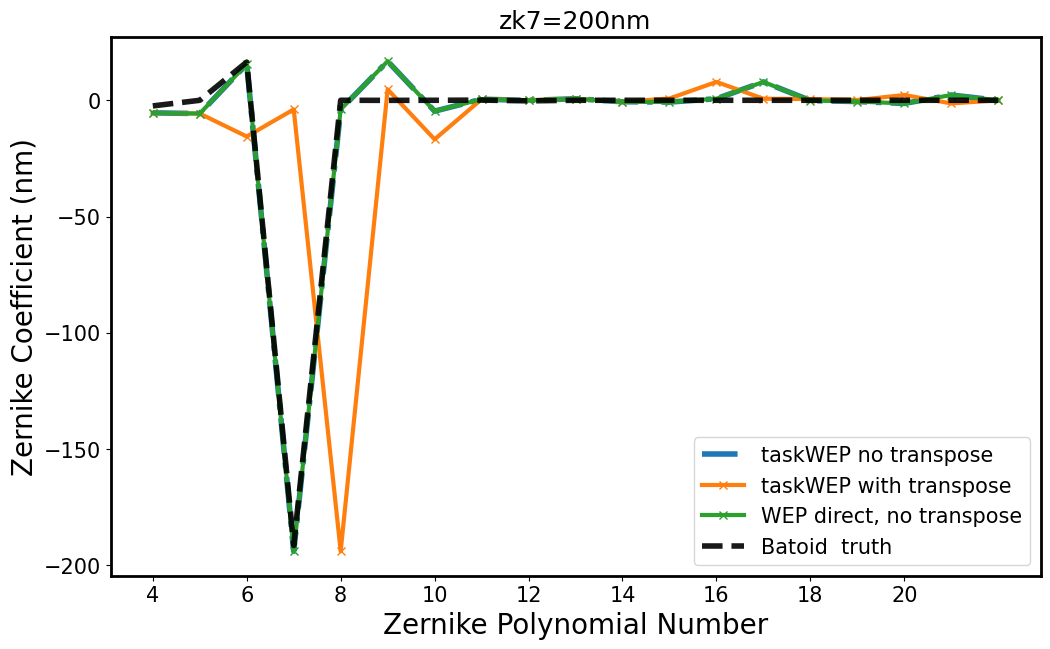

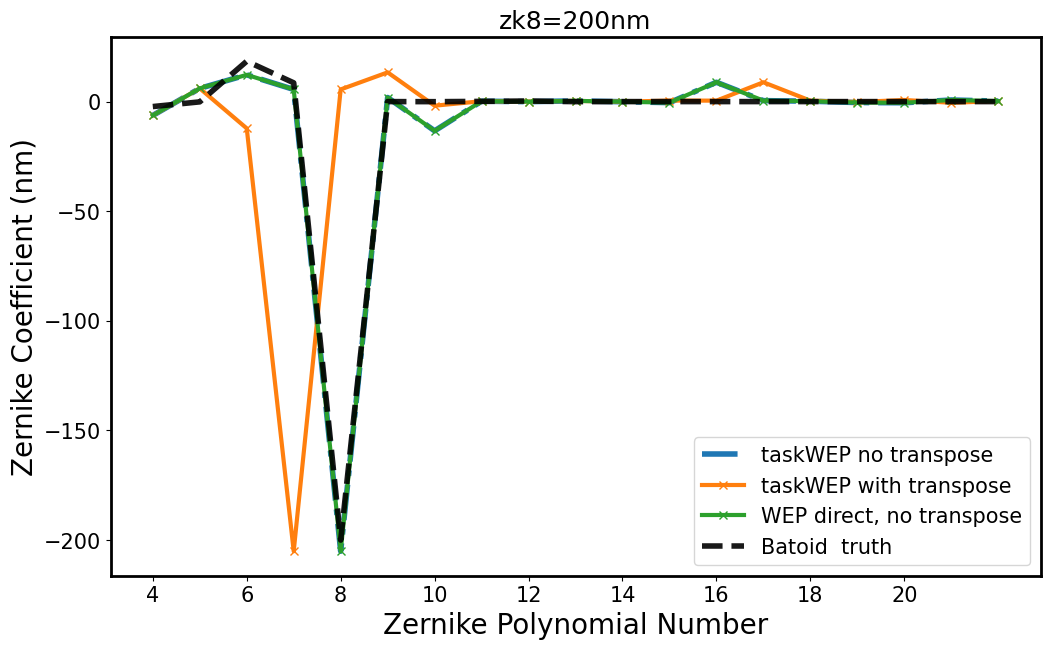

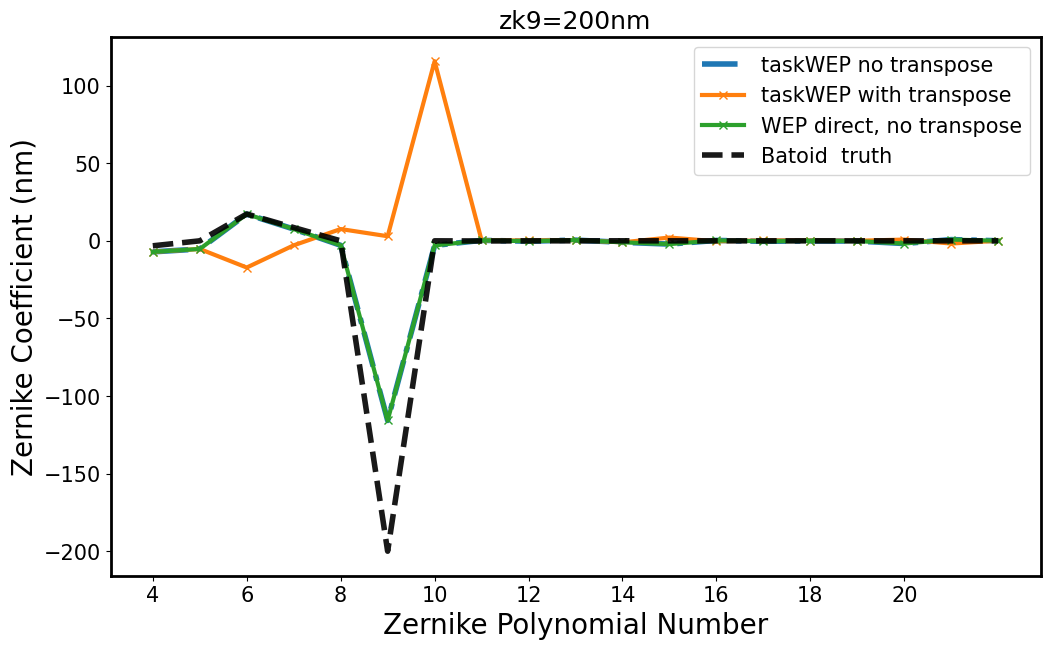

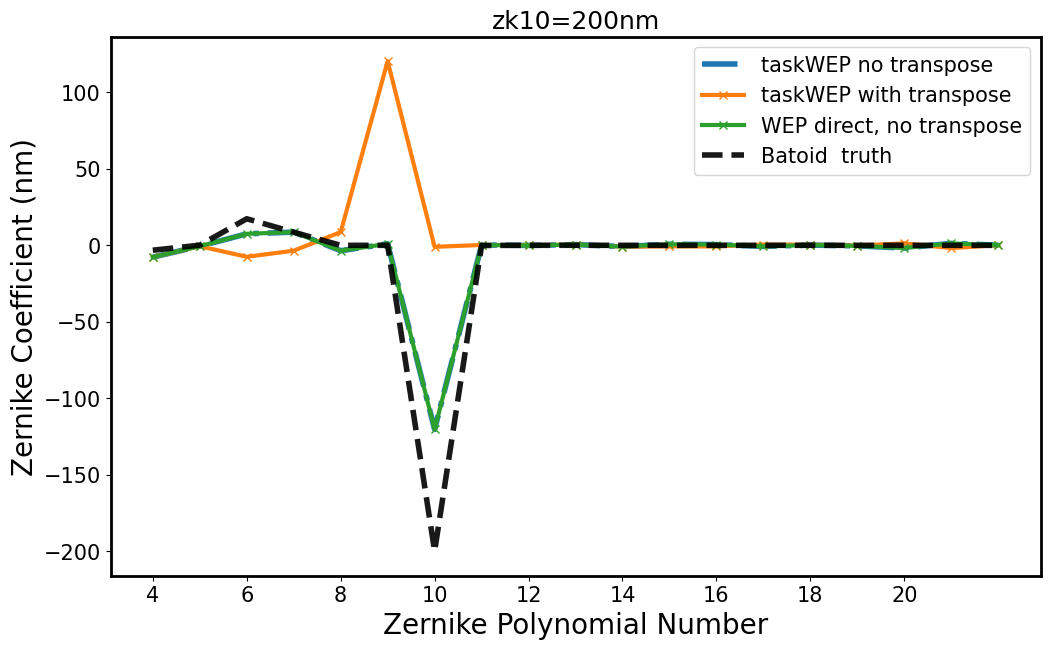

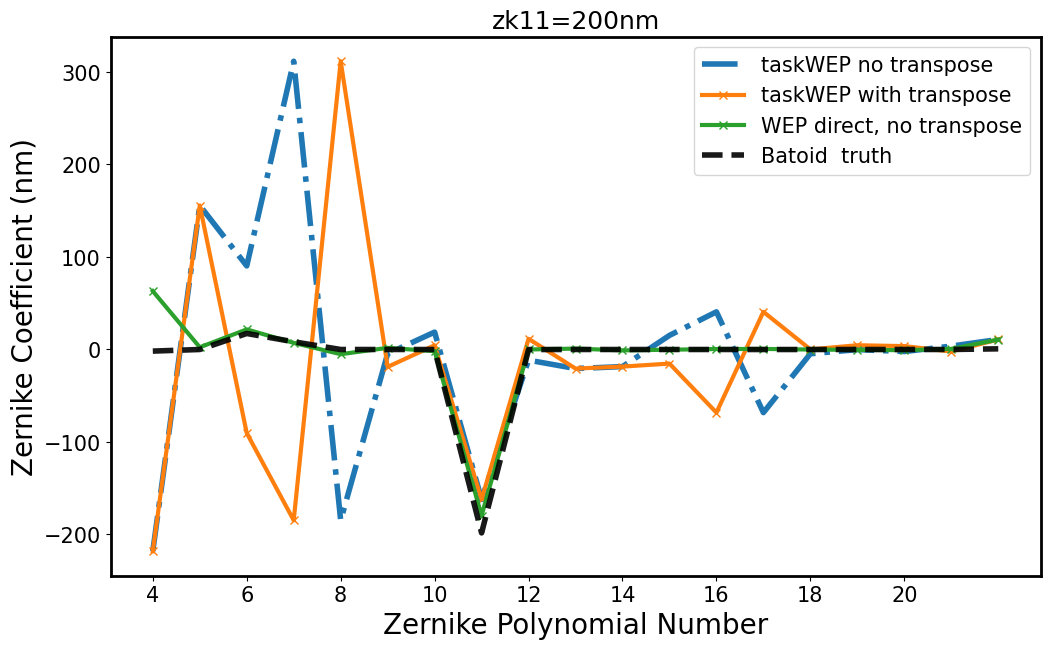

In [78]:
fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_no_transpose.npz')
file = np.load(fpath,allow_pickle=True)
results = file['results'].item()

fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_with_transpose.npz')
file = np.load(fpath,allow_pickle=True)
resultsT =  file['results'].item()

fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_cwfs_direct.npz')
file = np.load(fpath,allow_pickle=True)
resultsD = file['directresults'].item()

for i in range(5,12):
#i=5
    fig = plt.figure(figsize=(12,7))
    plt.plot(np.arange(4,23), results[i]['zernOutAvg']*1e3, '-.', lw=4, 
             label='taskWEP no transpose') # in microns
    plt.plot(np.arange(4,23), resultsT[i]['zernOutAvg']*1e3, '-x', lw=3, 
             label='taskWEP with transpose') # in microns

    plt.plot(np.arange(4,23), resultsD[i]['wepZk'], '-x', lw=3, 
             label='WEP direct, no transpose')
    # plt.plot(np.arange(4,23), resultsD[i]['cwfsZk'], '-x', lw=3, 
    #          label='CWFS direct, no transpose')


#     plt.plot(np.arange(4,23), resultsD[i]['wepZkSwap'], '-x', lw=3, 
#              label='WEP direct, no transpose, swap intra/extra')
    
    # plt.plot(np.arange(4,23), resultsD[i]['cwfsZkSwap'], '-x', lw=3, 
    #          label='CWFS direct, no transpose, swap intra/extra')


    plt.plot(np.arange(4,23), results[i]['truth'][4:]*1e9, ls='--',lw=4,c='k', alpha=0.9, 
             label='Batoid  truth') # in meters

    plt.legend()
    plt.xlabel('Zernike Polynomial Number')
    plt.ylabel('Zernike Coefficient (nm)')
    plt.title(f'zk{i}=200nm')
    plt.xticks(range(4,22)[::2])

# ax = fig.add_axes([0.7,0.5,0.2,0.2])
# ax.imshow(results[i]['donut_intra'][0].stamp_im.image.array)

In summary:
    
    * WEP without transpose (commenting out the `.T` operation carried out in `CalcZernikesTask` gives EXACTLY the same result as when interacting with WEP directly for zk5:10,  but for zk11 it's wild...
    * why is zk11 case so different than others? 
    

plot just zk11:

[]

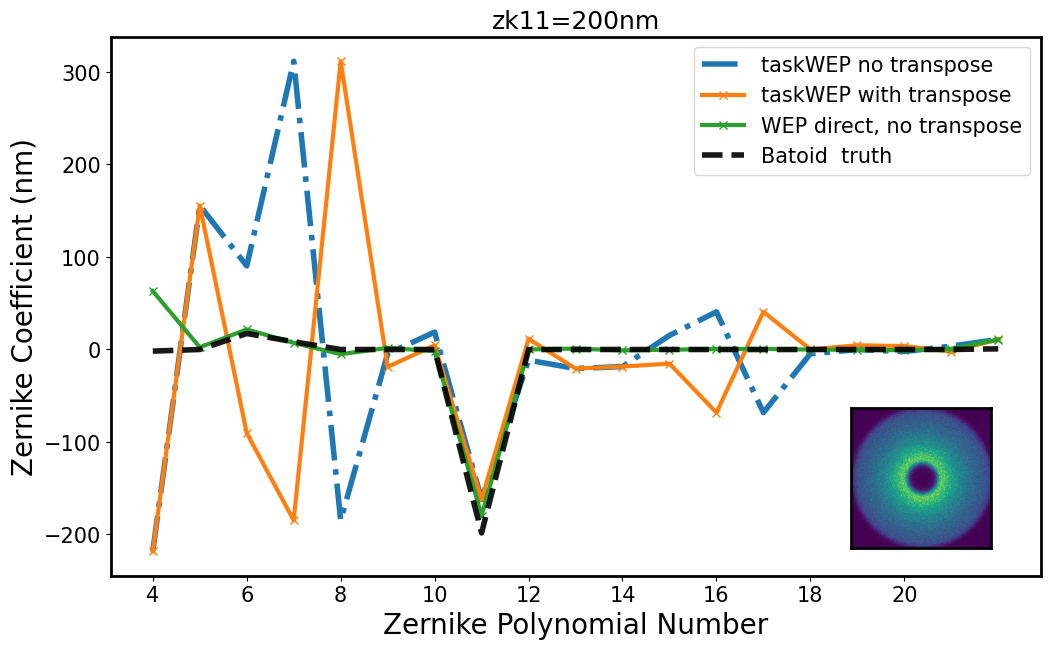

In [92]:
fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_no_transpose.npz')
file = np.load(fpath,allow_pickle=True)
results = file['results'].item()

fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_with_transpose.npz')
file = np.load(fpath,allow_pickle=True)
resultsT =  file['results'].item()

fpath = os.path.join('DM-37533',f'auxtel_b_seed{seed}_result_wep_cwfs_direct.npz')
file = np.load(fpath,allow_pickle=True)
resultsD = file['directresults'].item()

#for i in range(5,12):
i=11
fig = plt.figure(figsize=(12,7))
plt.plot(np.arange(4,23), results[i]['zernOutAvg']*1e3, '-.', lw=4, 
         label='taskWEP no transpose') # in microns
plt.plot(np.arange(4,23), resultsT[i]['zernOutAvg']*1e3, '-x', lw=3, 
         label='taskWEP with transpose') # in microns

plt.plot(np.arange(4,23), resultsD[i]['wepZk'], '-x', lw=3, 
         label='WEP direct, no transpose')
# plt.plot(np.arange(4,23), resultsD[i]['cwfsZk'], '-x', lw=3, 
#          label='CWFS direct, no transpose')


# plt.plot(np.arange(4,23), resultsD[i]['wepZkSwap'], '-x', lw=3, 
#              label='WEP direct, no transpose, swap intra/extra')

# plt.plot(np.arange(4,23), resultsD[i]['cwfsZkSwap'], '-x', lw=3, 
#          label='CWFS direct, no transpose, swap intra/extra')


plt.plot(np.arange(4,23), results[i]['truth'][4:]*1e9, ls='--',lw=4,c='k', alpha=0.9, 
         label='Batoid  truth') # in meters

plt.legend()
plt.xlabel('Zernike Polynomial Number')
plt.ylabel('Zernike Coefficient (nm)')
plt.title(f'zk{i}=200nm')
plt.xticks(range(4,22)[::2])

ax = fig.add_axes([0.7,0.15,0.2,0.2])
ax.imshow(results[i]['donut_intra'][0].stamp_im.image.array)
ax.set_yticks([])
ax.set_xticks([])